In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from similarity_searching_sketches.multi_hash_index_stats import ListStatsCounter
from similarity_searching_sketches.multi_hash_index_stats import bucket_stats
from similarity_searching_sketches.multi_hash_index_stats import bucket_sizes
from similarity_searching_sketches.multi_hash_index_stats import stats_to_pandas
from similarity_searching_sketches.multi_hash_index_stats import rq_candidate_set_size_stats
from similarity_searching_sketches.multi_hash_index import MultiHashIndex
from similarity_searching_sketches.persistence import load_np_array
from similarity_searching_sketches.utils import df_to_latex
from similarity_searching_sketches.visualization import hist_array
from similarity_searching_sketches.visualization import plot_array
%matplotlib inline

In [2]:
DATA_FOLDER='/home/matej/data/sketch-testing/dataset_10K/'
PIVOTS_PATH=DATA_FOLDER+'selected_pivots.npy'
MHI_DB_SAVE_PATH=DATA_FOLDER+'mhi_sketch_db.npy'
BUCKET_STATS_LATEX_SAVE_FILE=DATA_FOLDER+'bucket_stats.tex'
CANDIDATE_SET_SIZE_STATS_LATEX_SAVE_FILE=DATA_FOLDER+'candidate_set_size_stats.tex'
SKETCH_LEN=32
N_QUERY_OBJS=100
MAX_M=16

#### Prepare Sketch DB

In [3]:
sketch_db=load_np_array(MHI_DB_SAVE_PATH).T[:SKETCH_LEN].T

In [4]:
ids=np.arange(sketch_db.shape[0])

In [5]:
db=[(ids[i],sketch_db[i]) for i in range(sketch_db.shape[0])]
random.shuffle(db)
queries=db[:N_QUERY_OBJS]
sketch_db=db[N_QUERY_OBJS:]
del db

In [6]:
len(sketch_db)

9900

#### Initialize MHI's

In [7]:
m_list=range(1,MAX_M+1,1)
mhis=[MultiHashIndex(sketch_db, m) for m in m_list]

#### Compute stats  for MHI's buckets

In [8]:
bucket_stats_keys, bucket_stats=bucket_stats(mhis, m_list)

In [9]:
bucket_stats_df=stats_to_pandas(bucket_stats_keys, bucket_stats)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [10]:
bucket_stats_df

,m,r,Bucket count,Bucket size mean,Bucket size sum,m x Bucket size mean
0,1,0,9781,1.012166,9900,1.012166
1,2,1,10937,1.810368,19800,3.620737
2,3,2,3461,8.581335,29700,25.744005
3,4,3,984,40.243902,39600,160.975610
4,5,4,444,111.486486,49500,557.432432
5,6,5,256,232.031250,59400,1392.187500
6,7,6,176,393.750000,69300,2756.250000
7,8,7,128,618.750000,79200,4950.000000
8,9,8,112,795.535714,89100,7159.821429
9,10,9,96,1031.250000,99000,10312.500000


In [11]:
df_to_latex(BUCKET_STATS_LATEX_SAVE_FILE,bucket_stats_df)

#### Visualize bucket sizes

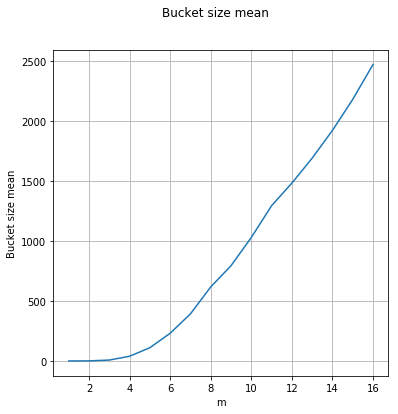

In [12]:
plot_array([None]+list(bucket_stats_df['Bucket size mean'].values), title='Bucket size mean', xlabel='m', ylabel='Bucket size mean', figsize=(6,6))

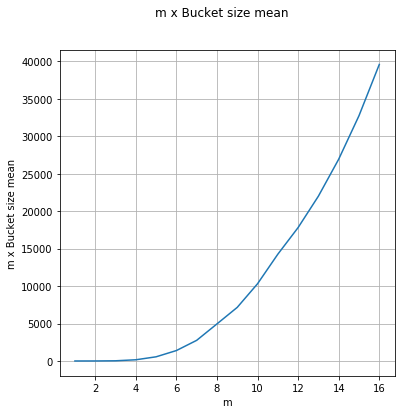

In [13]:
plot_array([None]+list(bucket_stats_df['m x Bucket size mean'].values), title='m x Bucket size mean', xlabel='m', ylabel='m x Bucket size mean', figsize=(6,6))

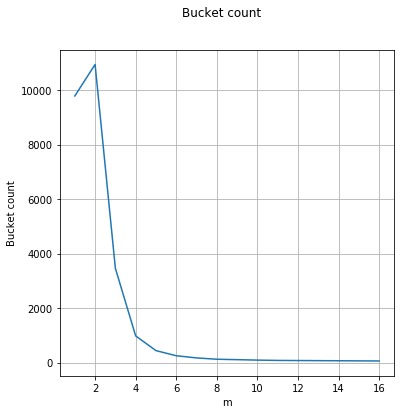

In [14]:
plot_array([None]+list(bucket_stats_df['Bucket count'].values), title='Bucket count', xlabel='m', ylabel='Bucket count', figsize=(6,6))

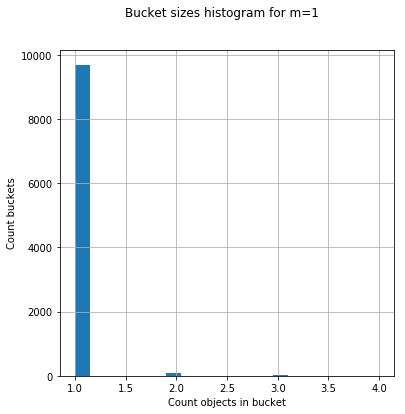

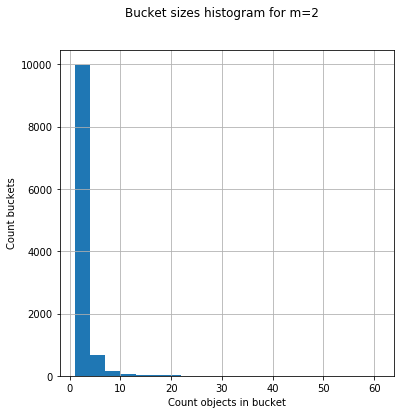

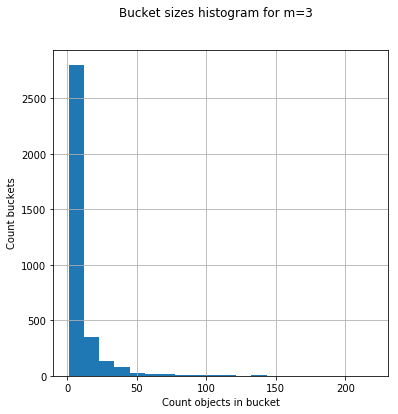

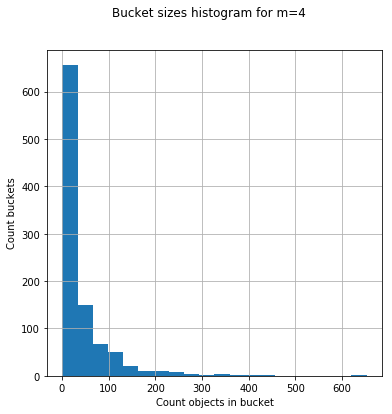

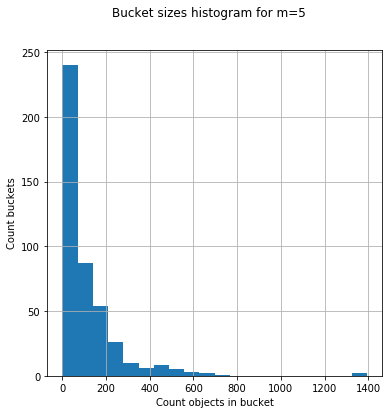

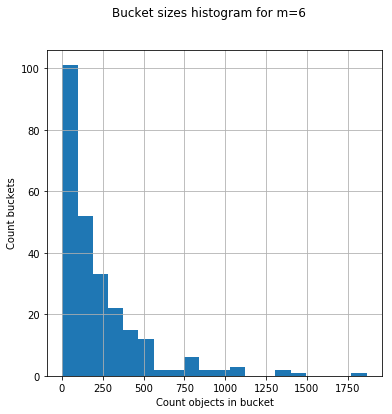

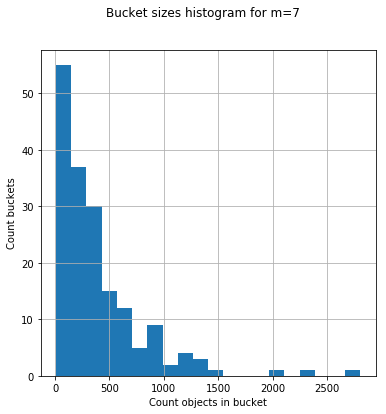

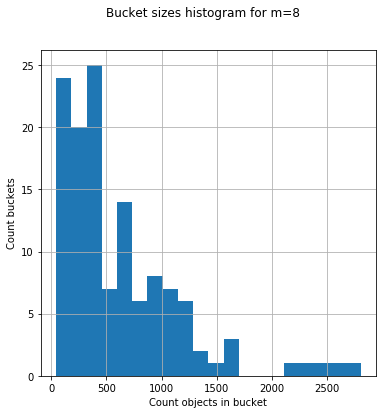

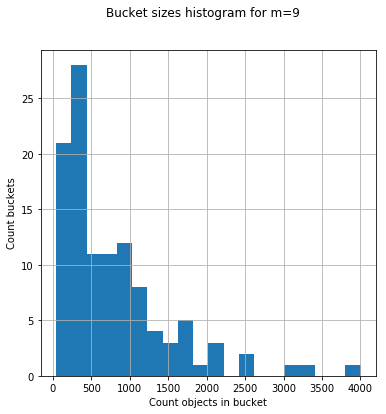

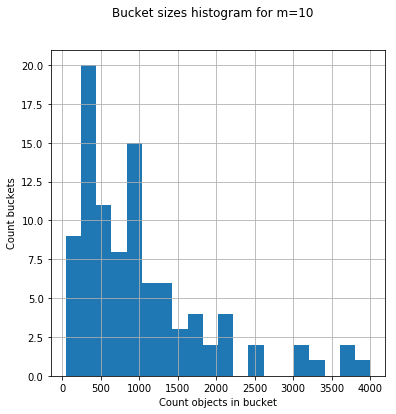

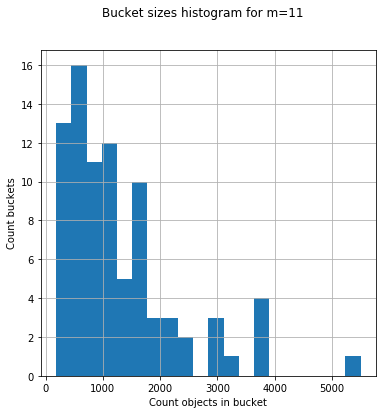

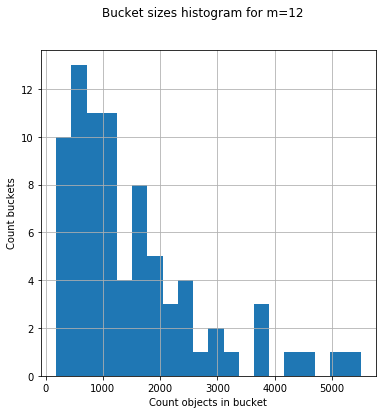

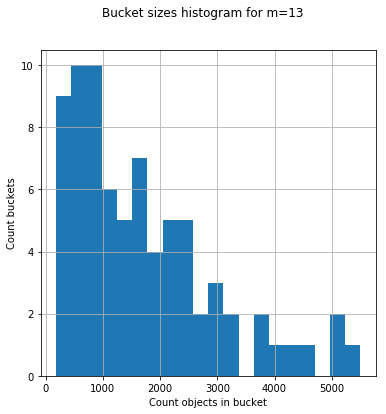

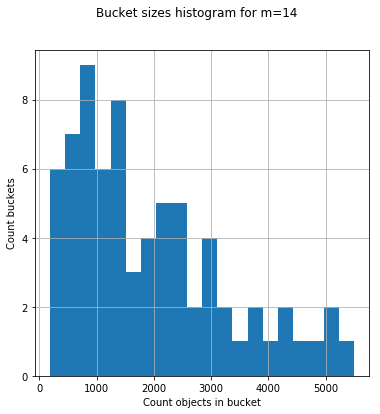

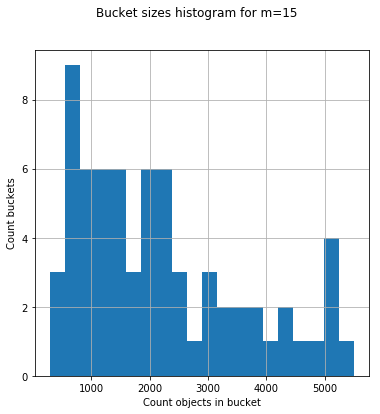

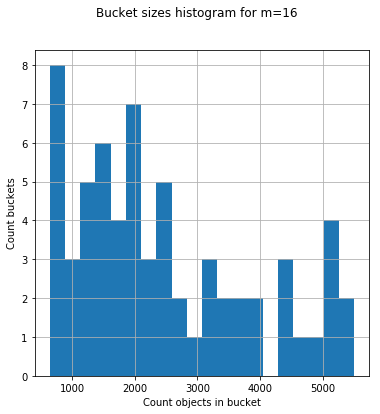

In [15]:
for i,mhi in enumerate(mhis):
    m=m_list[i]
    hist_array(bucket_sizes(mhi), bins=20, title='Bucket sizes histogram for m='+str(m), xlabel='Count objects in bucket', ylabel='Count buckets', figsize=(6,6))
    
    

#### Range query candidate set sizes

In [16]:
keys,stats=rq_candidate_set_size_stats(queries, mhis, m_list,len(sketch_db))
candidate_set_stats_df=stats_to_pandas(keys,stats)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


In [17]:
candidate_set_stats_df

,m,r,Mean TP count,m x Bucket size mean,Mean |C_1|+...+|C_m|,Mean |C|,Mean % bucket overlap,Mean % db filtered
0,1,0,0.01,1.012166,0.01,0.01,0.000000,99.999899
1,2,1,0.23,3.620737,6.89,6.88,0.145138,99.930505
2,3,2,1.33,25.744005,90.92,89.35,1.726793,99.097475
3,4,3,5.47,160.975610,446.51,427.89,4.170119,95.677879
4,5,4,17.36,557.432432,1415.58,1283.53,9.328332,87.035051
5,6,5,46.03,1392.187500,3069.33,2579.06,15.973193,73.948889
6,7,6,113.19,2756.250000,5463.38,4156.41,23.922370,58.016061
7,8,7,247.00,4950.000000,8282.01,5549.12,32.997908,43.948283
8,9,8,487.65,7159.821429,12393.29,7096.72,42.737401,28.315960
9,10,9,888.07,10312.500000,16707.62,8125.50,51.366502,17.924242


In [18]:
df_to_latex(CANDIDATE_SET_SIZE_STATS_LATEX_SAVE_FILE, candidate_set_stats_df)

/home/matej/project/similarity-searching-sketches/similarity_searching_sketches/multi_hash_index_stats.py:21: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return pd.DataFrame.from_dict({key: stats[key] for key in keys}).reindex_axis(keys, axis=1)


Text(0,0.5,"Count object ID's")

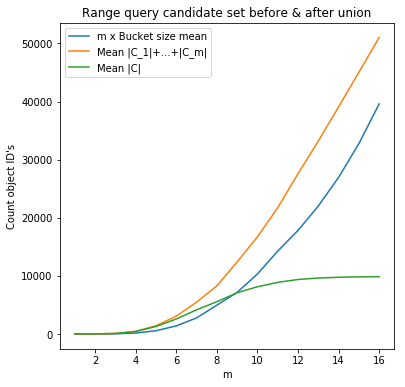

In [19]:
candidate_set_stats_df_with_m0=stats_to_pandas(keys, {key:[None]+stats[key] for key in stats.keys()})
candidate_set_stats_df_with_m0[['m x Bucket size mean','Mean |C_1|+...+|C_m|','Mean |C|']].plot(figsize=(6,6))
plt.title('Range query candidate set before & after union')
plt.xlabel('m')
plt.ylabel('Count object ID\'s')